In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")

In [3]:
import torch
import numpy as np
from pathlib import Path
import pickle
import matplotlib.pyplot as plt
from inpainting.visualizations import samples as vis
from inpainting.visualizations.digits import img_with_mask
import pandas as pd
from inpainting.evaluation import evaluation as ev
from tqdm import tqdm
from itertools import chain
from inpainting.evaluation.frechet_models import MNISTNet
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch.optim import Adam, SGD
from torch.nn import CrossEntropyLoss
from sklearn.metrics import accuracy_score
from inpainting.evaluation import fid
import seaborn as sns
from torch.utils.data import TensorDataset, DataLoader

In [20]:
mnist_experiments_paths = {
    "misgan": Path("../results/mnist/misgan/"),
    "torch_mfa": Path("../../gmm_missing/models/mnist"),
    "gmm_fullconv": Path("../results/mnist/long_trainings/fullconv_v1"),
    "gmm_linear_heads": Path("../results/mnist/long_trainings/linear_v1"),
}

celeba_32_experiments_paths = {
    "gmm_linear_heads": Path("../results/celeba/linear_heads/32x32/scripted_v2_after_fix"),
    "gmm_fullconv": Path("../results/celeba/fullconv/32x32/a_ampl_0.2"),
    "torch_mfa": Path("../../gmm_missing/models/celeba_32_32")
}
experiments_paths = celeba_32_experiments_paths

In [19]:
!ls ../../gmm_missing/models/celeba_32_32

model_c_300_l_10_init_rnd_samples.pth  val_predictions.pkl


In [21]:
experiments_results = dict()

for (name, path) in experiments_paths.items():
    with (path / "val_predictions.pkl").open("rb") as f:
        experiments_results[name] = pickle.load(f)

In [22]:
experiments_results.keys()

dict_keys(['gmm_linear_heads', 'gmm_fullconv', 'torch_mfa'])

In [7]:
# x, j, p, m ,a, d, y = experiments_results["torch_mfa"][0]

KeyError: 'torch_mfa'

In [ ]:
# [t.shape for t in [x, j, p, m, a, d, y]]

In [23]:
experiments_images = dict()

for (name, results) in experiments_results.items():
    experiments_images[name] = [(ev.outputs_to_images(*r), r[-1]) for r in results]

# NLL and MSE

In [27]:
ml_metrics = {
    name: [
        (ev.loss_like_metrics(res), res)
        for res in results
    ]
    for name, results in tqdm(experiments_results.items())
}





  0%|          | 0/3 [00:00<?, ?it/s]



 33%|███▎      | 1/3 [03:46<07:32, 226.46s/it]



 67%|██████▋   | 2/3 [07:30<03:45, 225.76s/it]



100%|██████████| 3/3 [11:23<00:00, 227.83s/it]


In [29]:
ml_metrics_df = pd.DataFrame([
    {
        "imputer_model": model,
#         "smieja_nll": m[1][-1][1] if len(m[1][-1].shape) > 0 else None,
        **m[0]
    }
    for model, metrics in ml_metrics.items()
    for m in metrics
])

ml_metrics_df

,imputer_model,nll,mse,signed_diff_mean,signed_diff_std
0,gmm_linear_heads,-1367.987427,6.818951,-0.014473,0.093170
1,gmm_linear_heads,-1392.762085,2.786407,0.016842,0.057869
2,gmm_linear_heads,-1022.258728,16.526936,0.064385,0.131897
3,gmm_linear_heads,-1332.309692,3.797112,-0.040396,0.057591
4,gmm_linear_heads,-1139.676636,10.760845,0.046879,0.108763
...,...,...,...,...,...
59596,torch_mfa,-1067.502686,6.275477,0.030591,0.085117
59597,torch_mfa,-1016.020264,5.263857,0.002180,0.082814
59598,torch_mfa,-819.699463,9.001827,-0.022029,0.106068
59599,torch_mfa,-259.012238,23.242245,0.020937,0.172812


In [30]:
# mfa_df = ml_metrics_df[ml_metrics_df.imputer_model == "torch_mfa"]
# mfa_df

In [31]:
ml_metrics_df.groupby("imputer_model").agg(["mean", "std"])

nll                    mse             \
                         mean         std       mean        std   
imputer_model                                                     
gmm_fullconv     -1287.113051  314.670553  12.968747   7.069914   
gmm_linear_heads -1222.857810  335.193425   7.736404   7.959923   
torch_mfa         -882.549091  243.946239   9.825910  10.052557   

                 signed_diff_mean           signed_diff_std            
                             mean       std            mean       std  
imputer_model                                                          
gmm_fullconv             0.047904  0.062884        0.097706  0.033239  
gmm_linear_heads        -0.004295  0.050806        0.079109  0.035006  
torch_mfa               -0.000799  0.044264        0.096575  0.039010

In [32]:
226 / (16*16*3)

0.2942708333333333

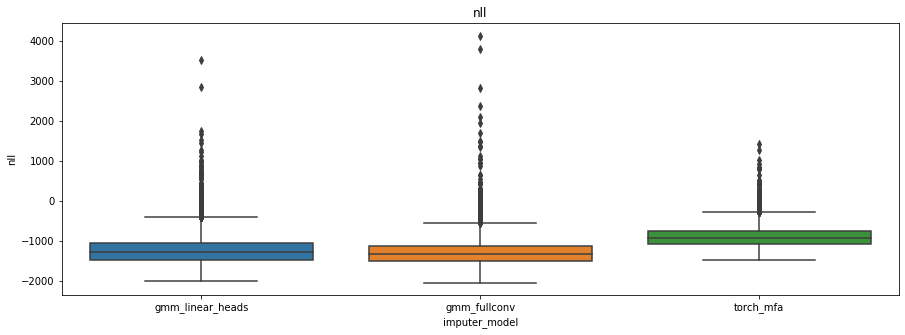

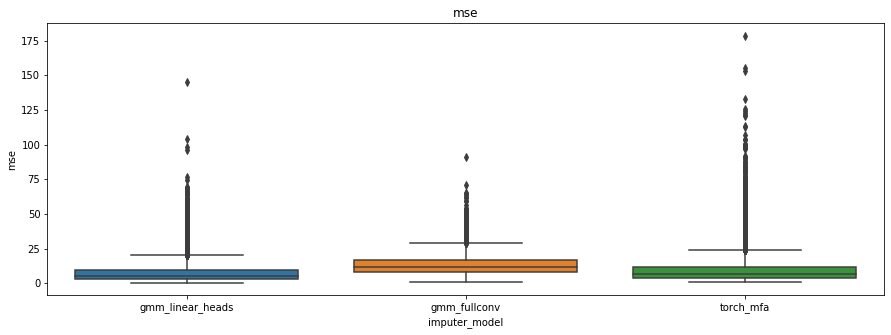

In [34]:
for metric in ["nll", "mse"]:
    plt.figure(figsize=(15, 5))
    plt.title(metric)
    sns.boxplot(
        data=ml_metrics_df,
        y=metric,
        # x="img_kind",
        x="imputer_model"
    )
    plt.show()

# Worst and best NLL cases for every model

gmm_linear_heads worst 5


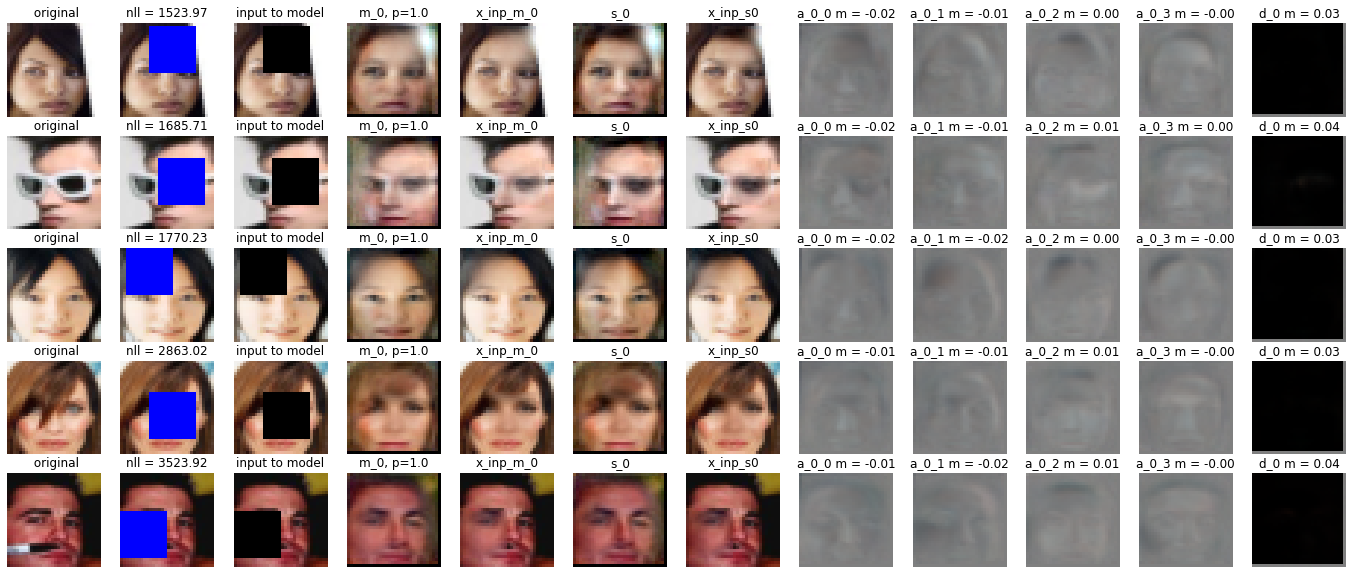

gmm_linear_heads best 5


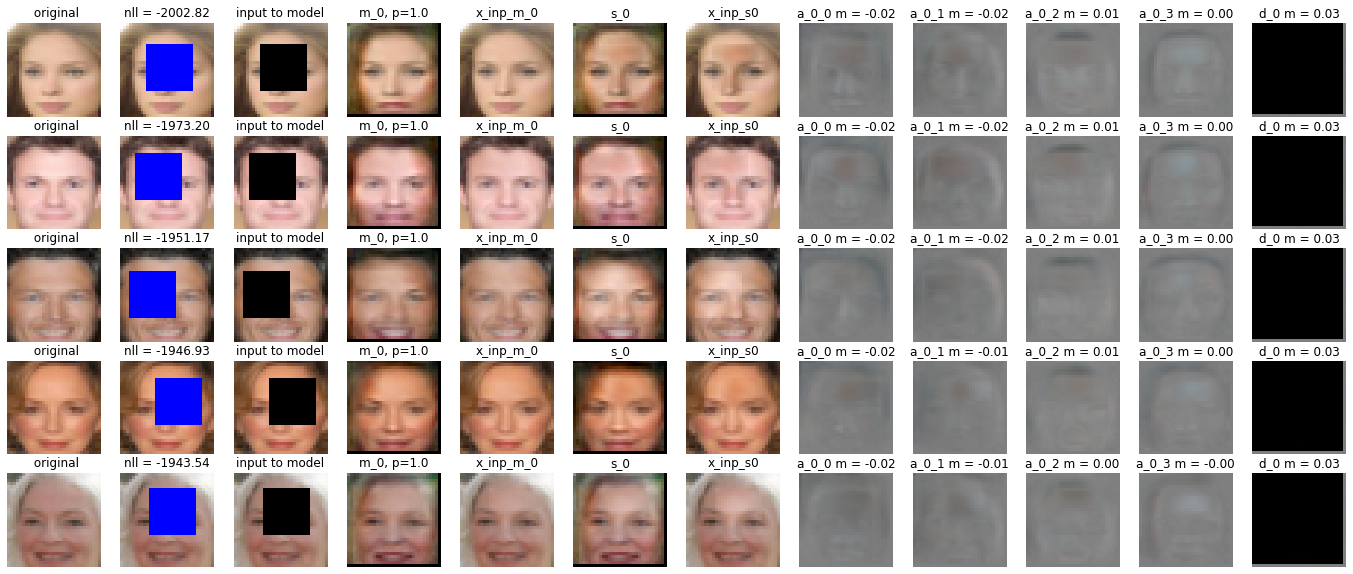

gmm_fullconv worst 5


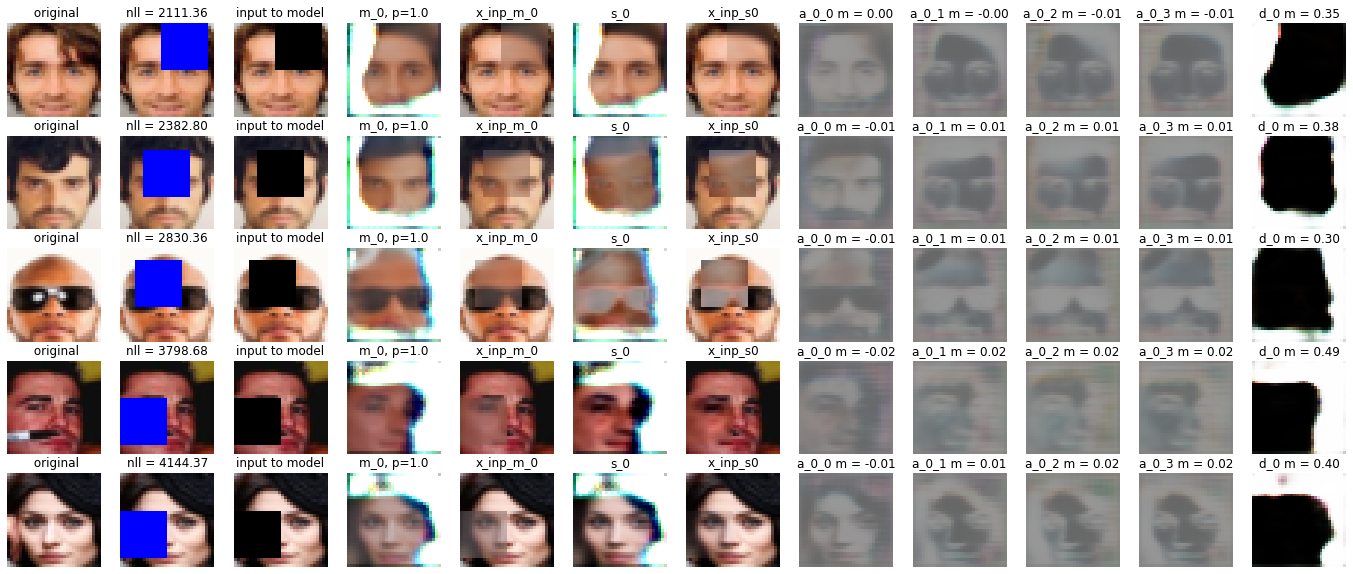

gmm_fullconv best 5


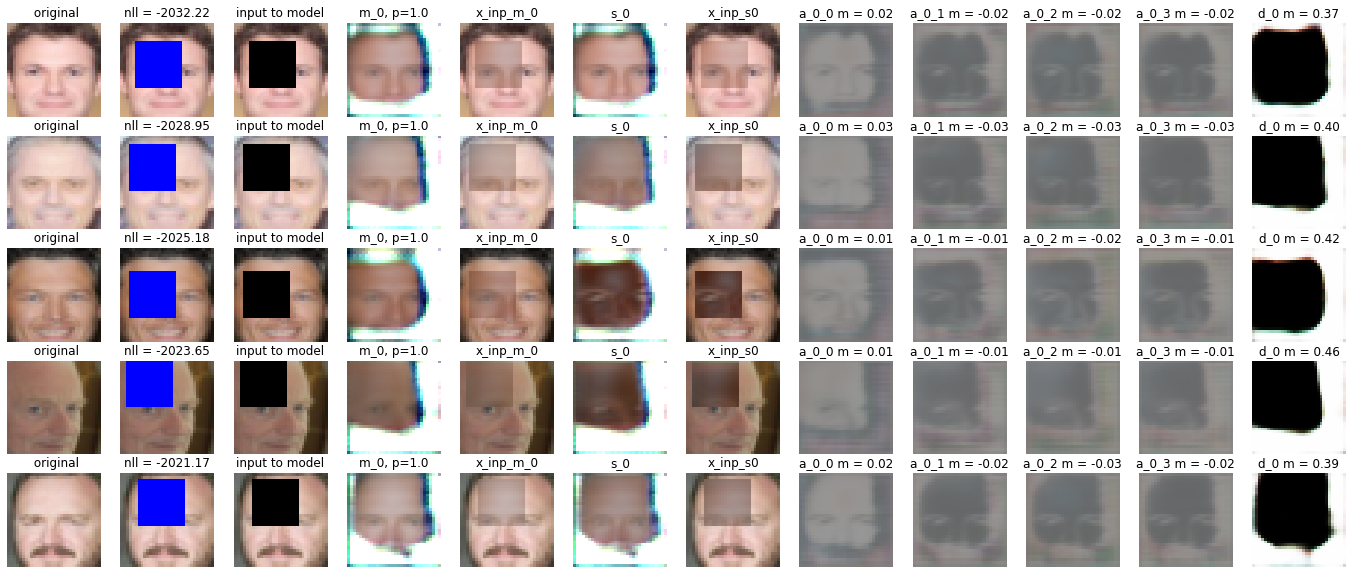

torch_mfa worst 5


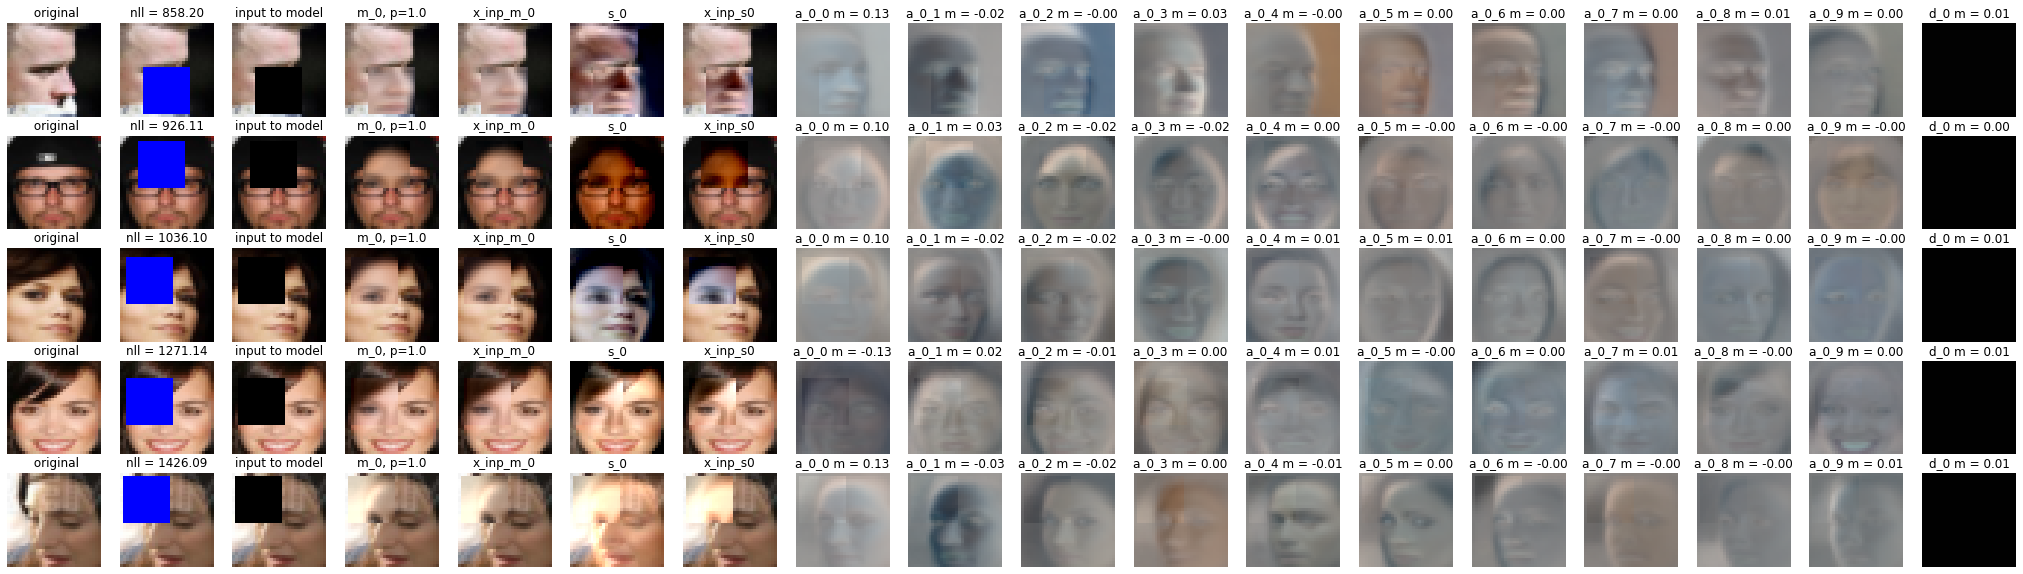

torch_mfa best 5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


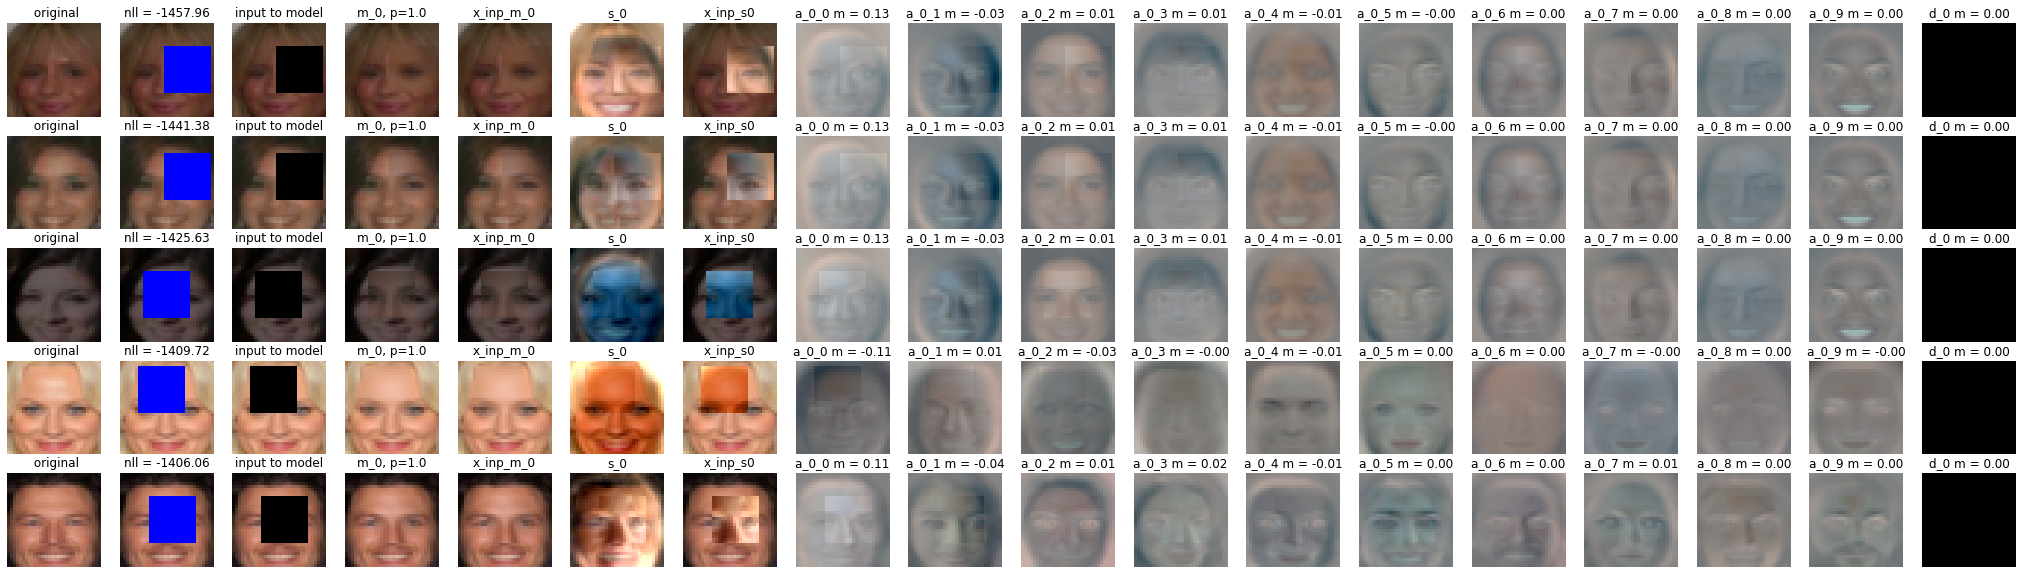

In [36]:
n = 5
for model, metrics_with_cases in ml_metrics.items():
    metrics_with_cases = sorted(
        metrics_with_cases, key = lambda m_c: m_c[0]["nll"]
    )
#     metrics_with_cases = [
#         m for m in metrics_with_cases if m[1][-1] != 1
#     ] 
    for (name, mwc) in [
        ("worst", metrics_with_cases[-n:]),
        ("best", metrics_with_cases[:n])
    ]:
        print(model, name, n)
        row_len = vis.row_length(
            *metrics_with_cases[0][1]
        )
        fig, ax = plt.subplots(nrows=n, ncols=row_len, figsize=(2* row_len, n * 2))
        for i, (m, c) in enumerate(mwc):
            vis.visualize_sample(
                *c,
                ax_row=ax[i]
            )
#             x_, j_, p_ ,m_, a_, d_, y_ = c
            
#             c = x_, j_, p_, m_+ 0.29, a_, d_, y_
#             vis.visualize_sample(
#                 *c,
#                 ax_row=ax[2*i+1]
#             )
            ax[i, 1].set_title(
                f"nll = {m['nll']:.2f}"
            )
        plt.show()



# Skimage metrics

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

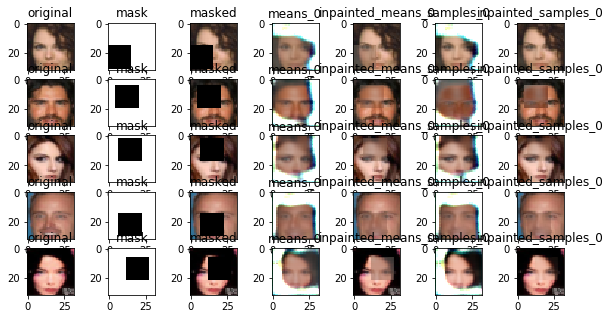

In [37]:
def plot_exp_images(images_dicts, figsize=(15,15)):
    width = len(images_dicts[0][0])
    height = len(images_dicts)
    fig, ax = plt.subplots(height,width, figsize=figsize)
    for i, (imgs, label) in enumerate(images_dicts):
        for j, (k, v) in enumerate(imgs.items()):
            ax[i][j].imshow(v.squeeze(), cmap="gray", vmin=0, vmax=1)
            ax[i][j].set_title(k)

plot_exp_images(experiments_images["gmm_fullconv"][:5], figsize=(10, 5))

In [38]:
experiments_metrics = {
    name: [
        {
            "metrics": ev.images_metrics(img_dict),
            "label": label
        }
        for (img_dict, label) in img_dicts
    ]
    for name, img_dicts in experiments_images.items()
}

/home/mprzewiezlikowski/anaconda3/envs/uj/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:160: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)
/home/mprzewiezlikowski/anaconda3/envs/uj/lib/python3.7/site-packages/skimage/metrics/_structural_similarity.py:108: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  im2[..., ch], **args)
../inpainting/evaluation/evaluation.py:82: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  "peak_signal_noise_ratio": lambda i1, i2,: peak_signal_noise_ratio(i1, i2)


In [39]:
per_image_metrics_df = pd.DataFrame([
    {
        "imputer_model": model,
        "label": label_metric["label"],
        **metric
    }
    for model, label_metrics in experiments_metrics.items()
    for label_metric in label_metrics
    for metric in label_metric["metrics"] #if metric["img_kind"] #in ["inpainted_means_0", "inpainted_samples_0"]
])
per_image_metrics_df

,imputer_model,label,img_kind,structural_similarity,peak_signal_noise_ratio
0,gmm_linear_heads,"[0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",original,1.000000,inf
1,gmm_linear_heads,"[0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",mask,0.103046,3.873466
2,gmm_linear_heads,"[0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",masked,0.669604,12.269063
3,gmm_linear_heads,"[0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",means_0,0.764936,17.095740
4,gmm_linear_heads,"[0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",inpainted_means_0,0.965665,26.537037
...,...,...,...,...,...
417202,torch_mfa,"([0], 454.1528625488281)",masked,0.555321,8.891952
417203,torch_mfa,"([0], 454.1528625488281)",means_0,0.909880,21.975757
417204,torch_mfa,"([0], 454.1528625488281)",inpainted_means_0,0.909880,21.975757
417205,torch_mfa,"([0], 454.1528625488281)",samples_0,0.444491,9.275044


In [40]:
per_image_metrics_df.drop("label", axis=1).groupby(
    ["imputer_model", "img_kind"]
).agg(
    lambda pts: "{0:.2f} ± {1:.2f}".format(np.mean(pts), np.std(pts) )
     ).reset_index().to_csv("ssim_psnr.csv")

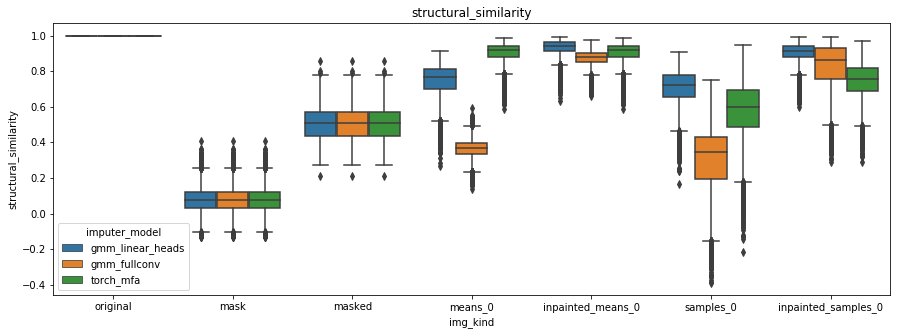

/home/mprzewiezlikowski/anaconda3/envs/uj/lib/python3.7/site-packages/numpy/lib/function_base.py:3949: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above
/home/mprzewiezlikowski/anaconda3/envs/uj/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1291: RuntimeWarning: invalid value encountered in double_scalars
  stats['iqr'] = q3 - q1
/home/mprzewiezlikowski/anaconda3/envs/uj/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
/home/mprzewiezlikowski/anaconda3/envs/uj/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
/home/mprzewiezlikowski/anaconda3/envs/uj/lib/python3.7/site-packages/numpy/lib/function_base.py:3949: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above
/home

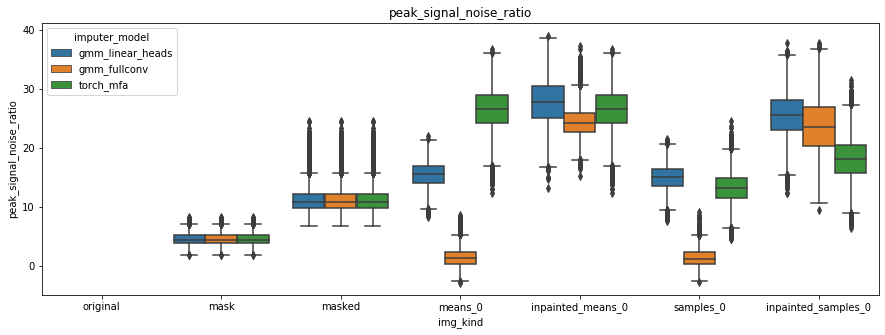

In [41]:
for metric in ["structural_similarity", "peak_signal_noise_ratio"]:
    plt.figure(figsize=(15, 5))
    plt.title(metric)
    sns.boxplot(
        data=per_image_metrics_df,
        y=metric,
        x="img_kind",
        hue="imputer_model"
    )
    plt.show()

# Example inpaintings of the same digit

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

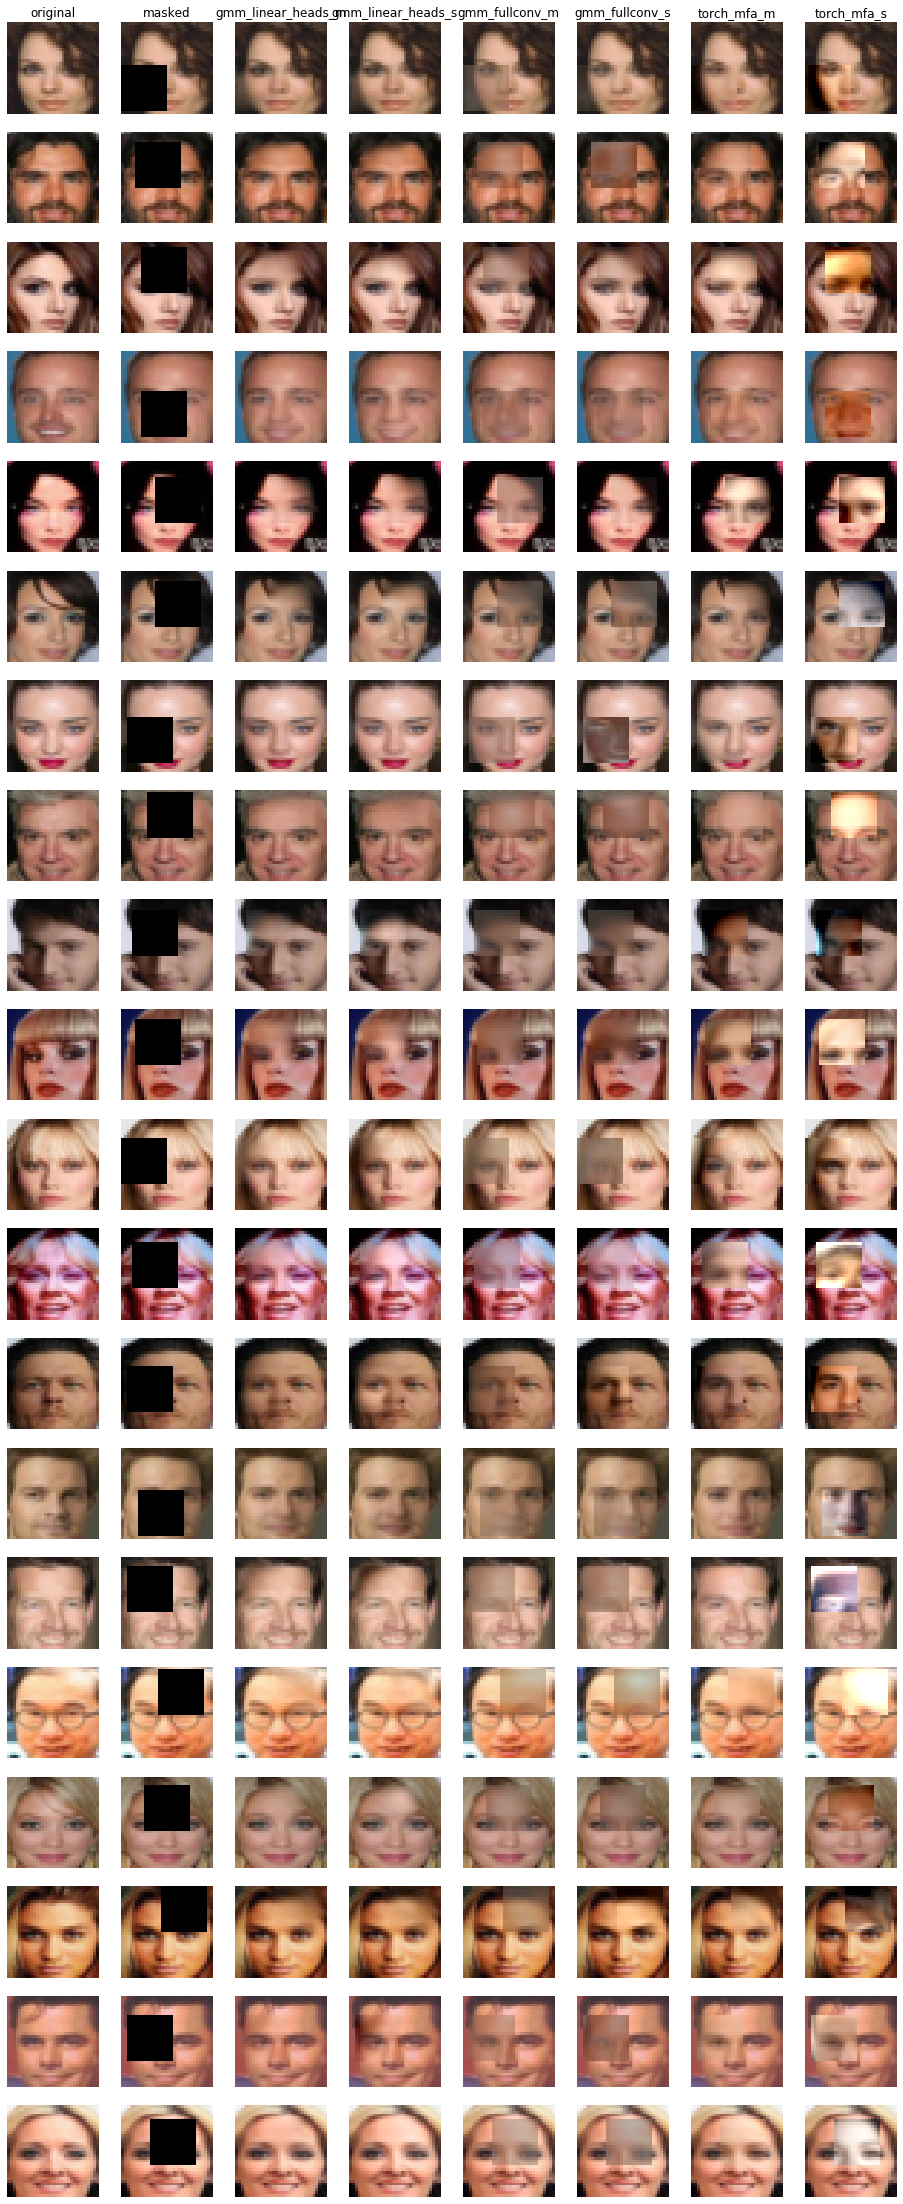

In [42]:
n_rows = 20
n_cols = (len(experiments_images.keys())*2) + 2
fig, ax = plt.subplots(
    nrows=n_rows, 
    ncols=n_cols,
    figsize=(n_cols*2, n_rows*2)
)
for i, (exp_name, imgs) in enumerate(experiments_images.items()):
    for c, img_name, brief_name in [
        ((2*i) + 2, "inpainted_means_0", "m"),
        ((2*i) + 3, "inpainted_samples_0", "s")        
    ]:
        ax[0, c].set_title(f"{exp_name}_{brief_name}")
        for j in range(n_rows):
            ax[j,c].imshow(imgs[j][0][img_name].squeeze(), vmin=0, vmax=1, cmap="gray")
            ax[j,c].axis("off")
    if i == 0:
        for c, img_name in [
            (0, "original"),
            (1, "masked")        
        ]:
            ax[0, c].set_title(f"{img_name}")
            for j in range(n_rows):
                ax[j,c].imshow(imgs[j][0][img_name].squeeze(), vmin=0, vmax=1, cmap="gray")
                ax[j,c].axis("off")

# Frechet distance

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

ds_train = MNIST(Path.home() / "uj" / "data", train=True, download=True, transform=ToTensor())
ds_val = MNIST(Path.home() / "uj" / "data", train=False, download=True, transform=ToTensor())

dl_train = DataLoader(ds_train, 1024, shuffle=True)
dl_val = DataLoader(ds_val, 256, shuffle=False)

classifier = MNISTNet()
opt = Adam(classifier.parameters(), 4e-3)
loss_fn = CrossEntropyLoss()

classifier.to(device)
for i in range(5):
    classifier.train()
    for X, y in tqdm(dl_train):
        opt.zero_grad()
        X, y = [t.to(device) for t in [X, y]]
        y_pred, _ = classifier(X)
        loss = loss_fn(y_pred, y)
        loss.backward()
        opt.step()
    classifier.eval()
    accs = []
    for (X,y ) in dl_val:
        X, y = [t.to(device) for t in [X, y]]
        y_pred, _ = classifier(X)
        logits = y_pred.argmax(1)
        accs.append(accuracy_score(y.cpu().numpy(), logits.cpu().numpy()))
    print(i, np.mean(accs))

In [ ]:
def images_loader(
    images,
    batch_size = 256
):
    return DataLoader(
        TensorDataset(
            torch.Tensor([
                img.transpose(2, 0, 1)
                for img in images
            ])
        ),
        batch_size=batch_size
    )
    

def frechet_distance(
    images_loader_1,
    images_loader_2,
    model=classifier
):
    (mu_1, s_1), (mu_2, s_2) = [
        fid.calculate_activation_statistics(
            il,
            len(il.dataset),
            model,
            feature_dim=128,
        )
        for il in [images_loader_1, images_loader_2]
    ]
    return fid.calculate_frechet_distance(
        mu_1, s_1, mu_2, s_2
    )

def grouped_by_kinds(images_dicts):
    return {
        k: [
            i_d[k] for (i_d, _) in images_dicts
        ]
        for k in images_dicts[0][0].keys()
    }
    


In [ ]:
experiments_images_by_kinds = {
    name: grouped_by_kinds(img_dicts)
    for name, img_dicts in experiments_images.items()
}

In [ ]:
frechet_dists = {
    name: {
        kind: frechet_distance(
            images_loader(kind_to_images["original"]),
            images_loader(images)
            )
        for kind, images in kind_to_images.items()
    }
    for name, kind_to_images in experiments_images_by_kinds.items()
}

In [ ]:
frechet_dists_df = pd.DataFrame([
    {
        "imputer_model": name,
        "kind": kind,
        "frechet_distance": fd
    }
    for name, kind_to_fd in frechet_dists.items()
    for kind, fd in kind_to_fd.items()
])

frechet_dists_df

In [ ]:
plt.figure(figsize=(15, 5))
sns.barplot(
    data=frechet_dists_df,
    y="frechet_distance",
    x="kind",
    hue="imputer_model",
)

In [ ]:
frechet_dists_df.to_csv("frechet_dists_tmp.csv")